# Set up

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
import xrft
from torch.utils.data import DataLoader, TensorDataset
from utils import *
from train_v1 import *
from loss import *
from UNET import *

In [2]:
base_path = "gs://leap-persistent/YueWang/SSH/data"

def open_zarr(path):
    return xr.open_zarr(path, consolidated=True)

train = open_zarr(f"{base_path}/train_eps5.zarr").compute()
val = open_zarr(f"{base_path}/val_eps5.zarr").compute()
test = open_zarr(f"{base_path}/test_eps5.zarr").compute()
zca = open_zarr(f"{base_path}/zca_eps5.zarr").compute()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_train = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
y_train = torch.from_numpy(train.zca_ubm.values).float().unsqueeze(1).to(device)

x_val = torch.from_numpy(val.ssh.values).float().unsqueeze(1).to(device)
y_val = torch.from_numpy(val.ubm.values).float().unsqueeze(1).to(device)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

zca_Vt_ubm = torch.from_numpy(zca.zca_Vt_ubm.values).float().to(device)
zca_mean_ubm = torch.from_numpy(zca.zca_mean_ubm.values).float().to(device)
zca_scale_ubm = torch.from_numpy(zca.zca_scale_ubm.values).float().to(device)

# Training

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

loss_train = GaussianLoss()
loss_val = MseLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(in_channels=1, out_channels=2, initial_features=32, depth=4)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_model(model, train_loader, val_loader,
            zca_Vt_ubm, zca_scale_ubm, zca_mean_ubm,
            loss_train, loss_val,
            optimizer, device,
            probabilistic=True,
            save_path ='/home/jovyan/GRL/checkpoint/eps5.pth',
            n_epochs = 20000, 
            patience = 50)

/srv/conda/envs/notebook/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: -6.66e-01, Val Loss: 4.61e-04, Epoch Time: 98.50s
Best model so far saved at epoch 1 (Val Loss: 4.610e-04)
Epoch 2, Train Loss: -9.88e-01, Val Loss: 2.91e-04, Epoch Time: 100.54s
Best model so far saved at epoch 2 (Val Loss: 2.908e-04)
Epoch 3, Train Loss: -1.12e+00, Val Loss: 1.56e-04, Epoch Time: 100.53s
Best model so far saved at epoch 3 (Val Loss: 1.565e-04)
Epoch 4, Train Loss: -1.15e+00, Val Loss: 9.45e-05, Epoch Time: 100.64s
Best model so far saved at epoch 4 (Val Loss: 9.451e-05)
Epoch 5, Train Loss: -1.17e+00, Val Loss: 7.52e-05, Epoch Time: 100.56s
Best model so far saved at epoch 5 (Val Loss: 7.523e-05)
Epoch 6, Train Loss: -1.19e+00, Val Loss: 8.01e-05, Epoch Time: 100.67s
Patience counter: 1/50
Epoch 7, Train Loss: -1.20e+00, Val Loss: 1.21e-04, Epoch Time: 100.72s
Patience counter: 2/50
Epoch 8, Train Loss: -1.20e+00, Val Loss: 5.52e-05, Epoch Time: 100.68s
Best model so far saved at epoch 8 (Val Loss: 5.521e-05)
Epoch 9, Train Loss: -1.21e+00, Val L

KeyboardInterrupt: 

# Testing

In [7]:
x_test.shape

torch.Size([2000, 1, 108, 108])

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32

x_test = torch.from_numpy(test.ssh.values).float().unsqueeze(1).to(device)
y_test = torch.from_numpy(test.ubm.values).float().unsqueeze(1).to(device)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def inverse_zca_transform(data_zca, zca_matrix, data_mean):
    num_images, img_rows, img_cols = data_zca.shape
    data_zca_flat = data_zca.reshape(num_images, img_rows * img_cols)
    inverse_zca_matrix = np.linalg.inv(zca_matrix.T)
    data_reconstructed_flat = np.dot(data_zca_flat, inverse_zca_matrix)
    data_reconstructed = data_reconstructed_flat + data_mean
    data_reconstructed = data_reconstructed.reshape(num_images, img_rows, img_cols)
    return data_reconstructed

def evaluate_model_zca(model, device, test_loader, zca_matrix, data_mean, ssh_test, checkpoint_path, probabilistic=False):
    """
    Evaluate model with flexibility for probabilistic or deterministic predictions.
    
    Args:
        model: Neural network model
        device: Computing device (CPU/GPU)
        test_loader: DataLoader for test data
        zca_matrix: ZCA whitening matrix
        data_mean: Mean used in ZCA whitening
        ssh_test: Sea surface height test data
        checkpoint_path: Path to model checkpoint
        probabilistic: Boolean flag for probabilistic prediction (default: False)
    
    Returns:
        If probabilistic:
            mu_zca_np: Mean predictions in ZCA space
            sigma_zca_np: Standard deviation predictions in ZCA space
            ubm_mu_pre: Mean predictions in original space
            bm_mu_pre: Balanced motion predictions
        If deterministic:
            None, None, ubm_pre, bm_pre: Same format but first two are None
    """
    model = model.to(device)
    model.eval()
    eps = 1e-6

    if os.path.isfile(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model parameters from {checkpoint_path}")
    else:
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

    predictions = []
    uncertainties = [] if probabilistic else None


    with torch.no_grad():
        for batch_x, _ in test_loader:
            batch_x = batch_x.to(device)
            outputs_zca = model(batch_x)
            
            if probabilistic:
                # Split into mean and uncertainty
                mu = outputs_zca[:, 0, ...]
                log_sigma = outputs_zca[:, 1, ...]
                sigma = torch.exp(log_sigma).clamp(min=eps)
                
                predictions.append(mu.cpu())
                uncertainties.append(sigma.cpu())
            else:
                # For deterministic case, output is already the prediction
                predictions.append(outputs_zca.cpu())

    # Process predictions
    if probabilistic:
        mu_zca_np = torch.cat(predictions, dim=0).numpy()
        sigma_zca_np = torch.cat(uncertainties, dim=0).numpy()
    else:
        # For deterministic case, ensure correct shape
        predictions_np = torch.cat(predictions, dim=0)
        if predictions_np.dim() == 4:  # If output includes channel dimension
            predictions_np = predictions_np.squeeze(1)
        mu_zca_np = predictions_np.numpy()
        sigma_zca_np = None
    
    # Apply inverse ZCA transformation
    ubm_prediction = xr_da(inverse_zca_transform(mu_zca_np, zca_matrix, data_mean), ssh_test)
    bm_prediction = ssh_test - ubm_prediction
    
    return mu_zca_np, sigma_zca_np, ubm_prediction, bm_prediction


# For probabilistic model
mu_zca, sigma_zca, mu_ubm, mu_bm = evaluate_model_zca(
    UNet(in_channels=1, out_channels=2, initial_features=16, depth=4), device, test_loader,
    zca.zca_matrix.values, zca.data_mean.values,
    test.ssh,
    '/home/jovyan/GRL/checkpoint/test1.pth',
    probabilistic=True
)

# # For deterministic model
# _, _, ubm_pred, bm_pred = evaluate_model_zca(
#     UNet(in_channels=1, out_channels=1, initial_features=16, depth=4), device, test_loader,
#     zca.regionA_matrix.values, zca.regionA_mean.values,
#     test.regionA_ssh,
#     '/home/jovyan/GRL/checkpoint/test1.pth',
#     probabilistic=False
# )

/tmp/ipykernel_2292/3645453528.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded model parameters from /home/jovyan/GRL/checkpoint/test1.pth


In [59]:
sigma_zca

array([[[0.44348887, 0.45896003, 0.42364168, ..., 0.24933839,
         0.278506  , 0.26657164],
        [0.4792005 , 0.5763683 , 0.4703828 , ..., 0.18146218,
         0.21819286, 0.25860396],
        [0.60722476, 0.64707947, 0.8161916 , ..., 0.15430859,
         0.19219634, 0.22941934],
        ...,
        [1.0679399 , 1.035753  , 0.9215538 , ..., 0.14223221,
         0.16747822, 0.20362978],
        [1.1558212 , 0.8440702 , 0.89456636, ..., 0.1745768 ,
         0.25000083, 0.2708416 ],
        [1.035742  , 1.0055532 , 1.287695  , ..., 0.2618147 ,
         0.32052666, 0.3406638 ]],

       [[0.45603442, 0.5059337 , 0.4039143 , ..., 0.28246439,
         0.30281252, 0.28480235],
        [0.5448873 , 0.5189691 , 0.36834782, ..., 0.20934668,
         0.2500238 , 0.2841164 ],
        [0.560587  , 0.48184013, 0.47589925, ..., 0.17516781,
         0.22175445, 0.25381115],
        ...,
        [0.24633428, 0.17830677, 0.15274407, ..., 0.14459658,
         0.17099434, 0.20267947],
        [0.3

In [22]:
mask = test.ubm.isnull().any(dim=['i', 'j'])

def remove_nan_samples(da, mask):
    return da.isel(sample=~mask)

ubm_true_clean = remove_nan_samples(test.ubm, mask)
ubm_zca_clean = remove_nan_samples(mu_ubm, mask)

In [51]:
def find_smallest_relative_error_indices(true_array, pred_array):
   # Calculate mean squared error per sample
   mse_per_sample = ((true_array - pred_array) ** 2).mean(axis=(1,2))
   
   # Calculate mean squared magnitude of true values per sample
   magnitude_per_sample = (true_array ** 2).mean(axis=(1,2))
   
   # Calculate relative error (MSE divided by magnitude)
   # Add small epsilon to avoid division by zero
   epsilon = 1e-10
   relative_error = mse_per_sample / (magnitude_per_sample + epsilon)
   

   best_indices = np.argsort(relative_error)[:30]
    
   worst_indices = np.argsort(relative_error)[-30:]
   
   return best_indices, worst_indices
    
best_indices, worst_indices = find_smallest_relative_error_indices(ubm_true_clean, ubm_zca_clean)

In [56]:
best_indices

<xarray.DataArray (sample: 30)> Size: 240B
array([1302, 1243, 1244,  209,  945, 1022,  631,   28,  210,  331,  944,
        644, 1295, 1321,  385, 1283, 1004,  932, 1301, 1320,  695,  102,
       1303,  509,  962, 1282,  996, 1003,  968, 1002])
Coordinates:
  * sample   (sample) int64 240B 21 22 23 24 25 26 27 ... 48 49 50 53 54 55 56

In [52]:
worst_indices

<xarray.DataArray (sample: 30)> Size: 240B
array([ 782, 1388,  495, 1375,  195,   60,  788, 1382, 1349,  459, 1143,
       1075, 1394, 1095,  229,  771, 1093,  775,  757, 1457,  795, 1094,
        759, 1112,  130, 1351, 1087, 1412, 1057, 1387])
Coordinates:
  * sample   (sample) int64 240B 1933 1934 1941 1942 ... 1971 1972 1973 1974

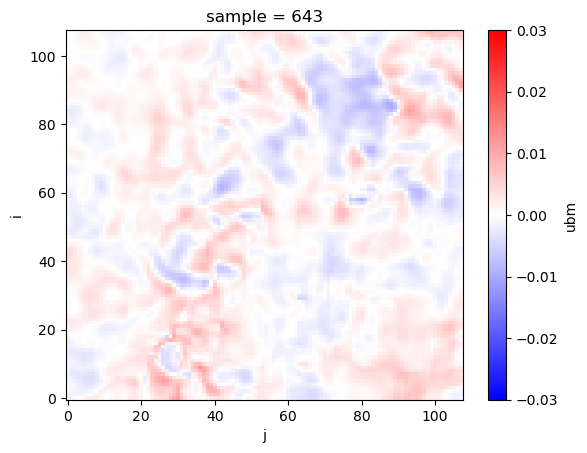

In [57]:
ubm_true_clean.isel(sample=495).plot(cmap='bwr', vmin=-0.03, vmax=0.03)

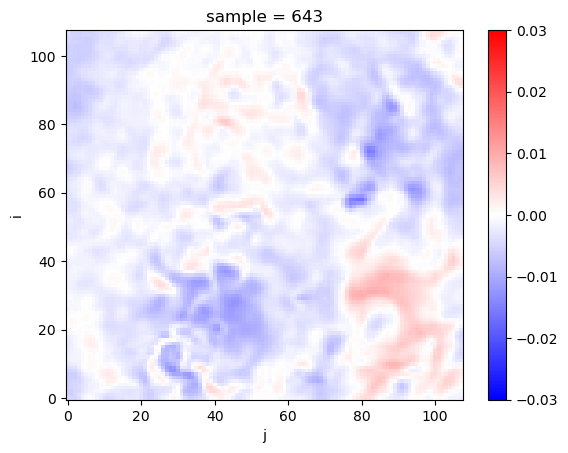

In [58]:
ubm_zca_clean.isel(sample=495).plot(cmap='bwr', vmin=-0.03, vmax=0.03)

/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/xrft/xrft.py:1054: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)


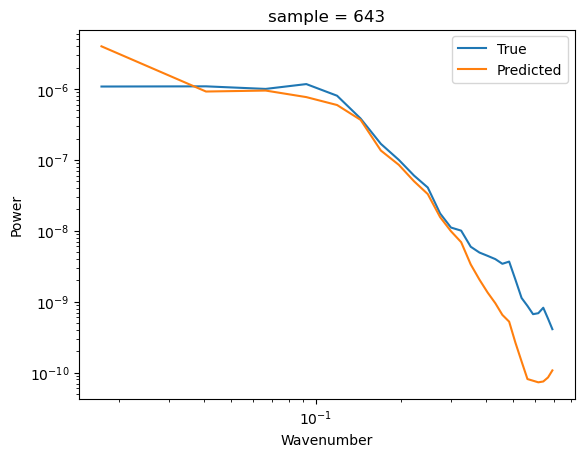

In [53]:
fig, ax = plt.subplots()

# Plot the first spectrum
isotropic_spectra(ubm_true_clean.isel(sample=495).compute()).plot(ax=ax, xscale='log', yscale='log', label='True')

# Plot the second spectrum on the same axes
isotropic_spectra(ubm_zca_clean.isel(sample=495).compute()).plot(ax=ax, xscale='log', yscale='log', label='Predicted')

# Set labels and legend
ax.set_xlabel('Wavenumber')
ax.set_ylabel('Power')
ax.legend()

plt.show()